In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', family='Arial')
from math import nan

from qtrendutils import linfit_utils as linfit
from qtrendutils import mapplot_utils as mymaps
from matplotlib.patches import Rectangle
from matplotlib.colors import BoundaryNorm
import scipy.stats as stats
import matplotlib as mpl
import matplotlib.patches as mpatches

import warnings
warnings.filterwarnings('ignore')

import sys
from qtrendutils import colormap_utils as mycolors
from qtrendutils import averaging_utils as avg
from qtrendutils import colorbar_utils as cbars

In [2]:
plotpath="/project/cas/islas/python_plots/qtrend_paper/figures/supplemental/"
trendpath="/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/1980_2020_trends/"

### Land Fraction

In [3]:
landfrac = xr.open_dataset("../../DATA_SORT/LANDFRAC_LENS2.nc")
landfrac = landfrac.landfrac
landfrac = landfrac.where(landfrac > 0, nan)
landfrac = landfrac.where(landfrac.lat > -60, nan) # omitting Antarctica

### Aridity Index

In [4]:
pet_tc = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/Aridity_Index/PET_Terraclim_1980_2020.nc")
pet_tc = pet_tc.mean('time')
ppt_tc = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/Aridity_Index/PPT_Terraclim_1980_2020.nc")
ppt_tc = ppt_tc.mean('time')
aridity = ppt_tc.ppt / pet_tc.pet
aridity['lon'] = landfrac.lon ; aridity['lat'] = landfrac.lat

In [5]:
aridmask = landfrac.where( (aridity > 0.05) & (aridity < 0.5), nan)
humidmask = landfrac.where( (aridity >= 0.5), nan)
hyperaridmask = landfrac.where( (aridity <= 0.05), nan)

aridmask = aridmask.where( aridmask.lat > -60, nan)
humidmask = humidmask.where( humidmask.lat > -60, nan)
hyperaridmask = hyperaridmask.where(hyperaridmask.lat > -60, nan)

### Read in the observational map data

In [6]:
#-----Vapor pressures
era5map = xr.open_dataset(trendpath+"vptrends_ERA5.nc")
era5map['lon'] = landfrac.lon ; era5map['lat'] = landfrac.lat
era5vp_map = era5map.vp


#------Precipitation
gpcp_map = xr.open_dataset(trendpath+'prtrends_GPCP.nc')
gpcp_map['lon'] = landfrac.lon ; gpcp_map['lat'] = landfrac.lat
gpcc_map = xr.open_dataset(trendpath+'prtrends_GPCC.nc')
gpcc_map['lon'] = landfrac.lon ; gpcc_map['lat'] = landfrac.lat
cruts_map = xr.open_dataset(trendpath+'prtrends_CRUTS.nc')
cruts_map['lon'] = landfrac.lon ; cruts_map['lat'] = landfrac.lat

### Read in the model based map data

In [7]:
cmip6vp_map = xr.open_dataset(trendpath+'vptrends_CMIP6.nc')
cmip6vp_map['lon'] = landfrac.lon ; cmip6vp_map['lat'] = landfrac.lat
cmip6pr_map = xr.open_dataset(trendpath+'prtrends_CMIP6.nc')*86400.
cmip6pr_map['lon'] = landfrac.lon ; cmip6pr_map['lat'] = landfrac.lat

cmip6vp_map_1mem = cmip6vp_map.isel(member=0)
cmip6pr_map_1mem = cmip6pr_map.isel(member=0)

#create a 1D member/model axis
cmip6vp_map = cmip6vp_map.stack(z=['model','member'])
cmip6pr_map = cmip6pr_map.stack(z=['model','member'])

testpoint = cmip6vp_map.vp.sel(lon=180, lat=0, method='nearest')
cmip6vp_map = cmip6vp_map.where(~np.isnan(testpoint), drop=True)
cmip6pr_map = cmip6pr_map.where(~np.isnan(testpoint), drop=True)

### Work out the deviations of ERA5 from the CMIP6 relation with precipitation (using all models and all members)

In [8]:
aglobal = np.zeros([cmip6pr_map.lat.size, cmip6pr_map.lon.size]) ; bglobal = np.zeros([cmip6pr_map.lat.size, cmip6pr_map.lon.size])
aglobal[:,:] = nan ; bglobal[:,:] = nan

for ilon in np.arange(0,cmip6pr_map.lon.size,1):
    for ilat in np.arange(0,cmip6pr_map.lat.size,1):
        if (landfrac[ilat,ilon] == 1):
            a_t, b_t = linfit.linfit_xy(cmip6pr_map.pr.isel(lon=ilon, lat=ilat), cmip6vp_map.vp.isel(lon=ilon, lat=ilat))
            aglobal[ilat,ilon] = a_t ; bglobal[ilat,ilon] = b_t
            
aglobal = xr.DataArray(aglobal, coords=[cmip6pr_map.lat, cmip6pr_map.lon], dims=['lat','lon'], name='aglobal')
bglobal = xr.DataArray(bglobal, coords=[cmip6pr_map.lat, cmip6pr_map.lon], dims=['lat','lon'], name='bglobal')

vppredict = aglobal + bglobal *cmip6pr_map.pr
residuals = cmip6vp_map.vp - vppredict
residualstdev = residuals.std(dim='z')

vppredict_gpcp = aglobal + bglobal*gpcp_map
vppredict_gpcc = aglobal + bglobal*gpcc_map
vppredict_cruts = aglobal + bglobal*cruts_map

era5vptrenddif_gpcp = era5map.vp - np.array(vppredict_gpcp.pr)
era5vptrenddif_gpcc = era5map.vp - np.array(vppredict_gpcc.pr)
era5vptrenddif_cruts = era5map.vp - np.array(vppredict_cruts.pr)

vpshading_afterp_gpcp = era5map.vp*nan
vpshading_afterp_gpcp = vpshading_afterp_gpcp.where( (era5vptrenddif_gpcp > 2*residualstdev) | (era5vptrenddif_gpcp < -2*residualstdev),1)
vpshading_afterp_gpcp = vpshading_afterp_gpcp.where( np.array(landfrac) > 0, nan)

vpshading_afterp_gpcc = era5map.vp*nan
vpshading_afterp_gpcc = vpshading_afterp_gpcc.where( (era5vptrenddif_gpcc > 2*residualstdev) | (era5vptrenddif_gpcc < -2*residualstdev),1)
vpshading_afterp_gpcc = vpshading_afterp_gpcc.where( np.array(landfrac) > 0, nan)

vpshading_afterp_cruts = era5map.vp*nan
vpshading_afterp_cruts = vpshading_afterp_cruts.where( (era5vptrenddif_cruts > 2*residualstdev) | (era5vptrenddif_cruts < -2*residualstdev),1)
vpshading_afterp_cruts = vpshading_afterp_cruts.where( np.array(landfrac) > 0, nan)

### Set up the joint pdf

In [9]:
def setupjointpdf( vpdata, svpdata, weights ):
    X, Y = np.mgrid[-1.500:1.525:122j, -25:25.5:102j] # probabilities represent per (0.025 precip, 0.1 vp)
    positions = np.vstack([X.ravel(), Y.ravel()])
    
    xplot = vpdata.flatten()
    yplot = svpdata.flatten()
    inputdata = np.vstack([xplot, yplot])
    kernel = stats.gaussian_kde(inputdata, weights=weights)
    Z = np.reshape(kernel(positions).T, X.shape)
    Z = np.moveaxis(Z, 1, 0)
    Xout = X[:,0] ; Yout = Y[0,:]
    return Z, Xout, Yout

In [10]:
datpath="/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/1980_2020_trends/"
era5vp_map = xr.open_dataset(datpath+'vptrends_ERA5.nc')
era5vp_map['lon'] = landfrac.lon ; era5vp_map['lat'] = landfrac.lat
era5q_map = era5vp_map.q

era5vp_clim = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/1980_1990_clims/vpclims_ERA5.nc")
era5vp_clim['lon'] = landfrac.lon ; era5vp_clim['lat'] = landfrac.lat
era5q_clim = era5vp_clim.q

era5landT_trend = era5vp_map.T2m*landfrac
era5landT_trend_m = avg.cosweightlonlat(era5landT_trend, 0, 360, -90, 90)

era5_q_trend_pcnt = (era5q_map / era5q_clim)*100.
#---Issues with normalizing locally since some T trends are near zero
#era5_q_trend_pcnt_norm = era5_q_trend_pcnt / era5vp_map.T2m
#---so normalizing by the land mean temperature instead
era5_q_trend_pcnt_norm = era5_q_trend_pcnt / era5landT_trend_m

In [11]:

cmip6vp_map = xr.open_dataset('/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/1980_2020_trends/vptrends_CMIP6.nc')
cmip6vp_map['lon'] = landfrac.lon ; cmip6vp_map['lat'] = landfrac.lat
cmip6q_map = cmip6vp_map.q

cmip6vp_clim = xr.open_dataset('/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/1980_2020_clims/vpclims_CMIP6.nc')
cmip6vp_clim['lon'] = landfrac.lon ; cmip6vp_clim['lat'] = landfrac.lat
cmip6q_clim = cmip6vp_clim.q

cmip6_q_trend_pcnt = (cmip6q_map / cmip6q_clim)*100.

#----Issues with normalizing locally since some T trends are near zero
#cmip6_q_trend_pcnt_norm = cmip6_q_trend_pcnt / cmip6vp_map.tas
cmip6_t_trend = avg.cosweightlonlat(cmip6vp_map.tas*landfrac,0,360,-90,90)
cmip6_q_trend_pcnt_norm = cmip6_q_trend_pcnt / cmip6_t_trend

cmip6pr_map = xr.open_dataset('/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/1980_2020_trends/prtrends_CMIP6.nc')*86400.
cmip6pr_map['lon'] = landfrac.lon ; cmip6pr_map['lat'] = landfrac.lat
cmip6pr_map = cmip6pr_map.pr


lens2vp_map = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/1980_2020_trends/vptrends_LENS2.nc")
lens2vp_map['lon'] = landfrac.lon ; lens2vp_map['lat'] = landfrac.lat
lens2q_map = lens2vp_map.q

lens2pr_map = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/1980_2020_trends/prtrends_LENS2.nc")
lens2pr_map['lon'] = landfrac.lon ; lens2pr_map['lat'] = landfrac.lat

lens2vp_clim = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/1980_1990_clims/vpclims_LENS2.nc")
lens2vp_clim['lon'] = landfrac.lon ; lens2vp_clim['lat'] = landfrac.lat
lens2q_clim = lens2vp_clim.q

lens2_q_trend_pcnt = (lens2q_map / lens2q_clim)*100.

lens2_t_trend = avg.cosweightlonlat(lens2vp_map.TREFHT*landfrac,0,360,-90,90)
lens2_q_trend_pcnt_norm = lens2_q_trend_pcnt / lens2_t_trend

In [12]:
cmip6q_map_1mem = cmip6_q_trend_pcnt_norm.isel(member=0)
cmip6pr_map_1mem = cmip6pr_map.isel(member=0)

cmip6q_map = cmip6_q_trend_pcnt_norm.stack(z=['model','member'])
cmip6pr_map = cmip6pr_map.stack(z=['model','member'])

testpoint = cmip6q_map.sel(lon=180, lat=0, method='nearest')

cmip6q_map = cmip6q_map.where( ~np.isnan(testpoint), drop=True )
cmip6pr_map = cmip6pr_map.where( ~np.isnan(testpoint), drop=True )

In [13]:
cmip6q_arid = cmip6q_map_1mem*aridmask ; cmip6pr_arid = cmip6pr_map_1mem*aridmask
cmip6q_arid = cmip6q_arid.stack(z=['lon','lat']).dropna('z')
cmip6pr_arid = cmip6pr_arid.stack(z=['lon','lat']).dropna('z')

cmip6q_arid_allmem = cmip6q_map*aridmask ; cmip6pr_arid_allmem = cmip6pr_map*aridmask
cmip6q_arid_allmem = cmip6q_arid_allmem.stack(loc=['lon','lat']).dropna('loc')
cmip6pr_arid_allmem = cmip6pr_arid_allmem.stack(loc=['lon','lat']).dropna('loc')

lens2q_arid = lens2_q_trend_pcnt_norm*aridmask ; lens2pr_arid = lens2pr_map*aridmask
lens2q_arid = lens2q_arid.stack(z=['lon','lat']).dropna('z')
lens2pr_arid = lens2pr_arid.stack(z=['lon','lat']).dropna('z')


#----basing which grid points to drop on GPCC since it has a few extra NaN's around the coast
gpcc_arid = gpcc_map*aridmask 
gpcc_arid = gpcc_arid.stack(z=['lon','lat'])#.dropna('z')

cruts_arid = cruts_map*aridmask
cruts_arid = cruts_arid.stack(z=['lon','lat'])
cruts_arid = cruts_arid.where( ~np.isnan(gpcc_arid), drop=True)
gpcp_arid = gpcp_map*aridmask
gpcp_arid = gpcp_arid.stack(z=['lon','lat'])
gpcp_arid = gpcp_arid.where( ~np.isnan(gpcc_arid), drop=True)
era5_arid = era5_q_trend_pcnt_norm*aridmask
era5_arid = era5_arid.stack(z=['lon','lat'])
era5_arid = era5_arid.where( ~np.isnan(gpcc_arid.pr), drop=True)
gpcc_arid = gpcc_arid.dropna("z")

In [14]:
# Drop lingering NaN's
idrop = np.argwhere( np.isnan(np.array(cruts_arid.pr)) | np.isnan(np.array(gpcp_arid.pr)) | np.isnan(np.array(gpcc_arid.pr)) | np.isnan(np.array(era5_arid)) )
cruts_arid = cruts_arid.drop_isel(z=idrop)
gpcp_arid = gpcp_arid.drop_isel(z=idrop)
gpcc_arid = gpcc_arid.drop_isel(z=idrop)
era5_arid = era5_arid.drop_isel(z=idrop)

In [15]:
def setupjointpdf( vpdata, svpdata, weights ):
    X, Y = np.mgrid[-1.500:1.525:122j, -25:25.5:102j] # probabilities represent per (0.025 precip, 0.5%/K)
    positions = np.vstack([X.ravel(), Y.ravel()])
    
    xplot = vpdata.flatten()
    yplot = svpdata.flatten()
    inputdata = np.vstack([xplot, yplot])
    kernel = stats.gaussian_kde(inputdata, weights=weights)
    Z = np.reshape(kernel(positions).T, X.shape)
    Z = np.moveaxis(Z, 1, 0)
    Xout = X[:,0] ; Yout = Y[0,:]
    return Z, Xout, Yout

In [16]:
for imodel in np.arange(0,cmip6q_arid.model.size,1):
    prdat = cmip6pr_arid.isel(model=imodel)
    qdat = cmip6q_arid.isel(model=imodel)
    w = np.cos(np.deg2rad(prdat.lat))
    zi, x, y = setupjointpdf(np.array(prdat), np.array(qdat), w)
    if (imodel == 0):
        zcmip6_weighted = xr.DataArray(np.zeros([cmip6pr_arid.model.size, len(y), len(x)]),
                                       coords=[cmip6pr_arid.model, y, x], dims=['model','y','x'], name='cmip6_prob')
    zcmip6_weighted[imodel,:,:] = zi[:,:]

In [17]:
zgpcp, x, y = setupjointpdf(np.array(gpcp_arid.pr), np.array(era5_arid), np.cos(np.deg2rad(era5_arid.lat)))
zgpcc, x, y = setupjointpdf(np.array(gpcc_arid.pr), np.array(era5_arid), np.cos(np.deg2rad(era5_arid.lat)))
zcruts, x, y = setupjointpdf(np.array(cruts_arid.pr), np.array(era5_arid), np.cos(np.deg2rad(era5_arid.lat)))

In [18]:
def setup_q_vs_pr(x1, x2, y1, y2, titlestr, yticks=True):
    ax = fig.add_axes([x1, y1, x2-x1, y2-y1])
    ax.set_ylim(-13,17)
    ax.set_xlim(-0.4,0.4)
    
    ax.plot([0,0],[-13,17], color='black')
    ax.plot([-0.4,0.4],[0,0], color='black')
    
    ax.set_yticks([-10,-5,0,5,10,15])
    ax.set_xticks([-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,0.3,0.4])

    if (yticks):  
        ax.set_yticklabels(['-10','-5','0','5','10','15'], fontsize=14)
        ax.set_ylabel('Specific Humidity Trend (%/K)', fontsize=14)
    else:
        ax.set_yticklabels([' ',' ',' ',' ',' ',' '], fontsize=14)
        
    ax.set_xticklabels(['-0.4','-0.3','-0.2','-0.1','0','0.1','0.2','0.3','0.4'], fontsize=14)
    
    ax.set_xlabel('Precipitation trend (mm/day/41y)', fontsize=14)
    ax.set_title(titlestr, fontsize=16)
    
    return ax

In [19]:
bins = np.arange(-0.325,0.325,0.05)
digitized = np.digitize(gpcc_arid.pr, bins)
weights = np.cos(np.deg2rad(gpcc_arid.lat))
pr_obs_gpcc = [ ( ((gpcc_arid.pr[digitized == i]*weights[digitized == i]).sum('z')) / weights[digitized == i].sum('z') ) for i in range(0,len(bins)) ]
q_obs_gpcc = [ ( ((era5_arid[digitized == i]*weights[digitized == i]).sum('z')) / weights[digitized == i].sum('z') ) for i in range(0,len(bins)) ]

digitized = np.digitize(gpcp_arid.pr, bins)
weights = np.cos(np.deg2rad(gpcp_arid.lat))
pr_obs_gpcp = [ ( ((gpcp_arid.pr[digitized == i]*weights[digitized == i]).sum('z')) / weights[digitized == i].sum('z') ) for i in range(0,len(bins)) ]
q_obs_gpcp = [ ( ((era5_arid[digitized == i]*weights[digitized == i]).sum('z')) / weights[digitized == i].sum('z') ) for i in range(0,len(bins)) ]

digitized = np.digitize(cruts_arid.pr, bins)
weights = np.cos(np.deg2rad(cruts_arid.lat))
pr_obs_cruts = [ ( ((cruts_arid.pr[digitized == i]*weights[digitized == i]).sum('z')) / weights[digitized == i].sum('z') ) for i in range(0,len(bins)) ]
q_obs_cruts = [ ( ((era5_arid[digitized == i]*weights[digitized == i]).sum('z')) / weights[digitized == i].sum('z') ) for i in range(0,len(bins)) ]

pr_cmip6 = xr.DataArray(np.zeros([cmip6q_arid.model.size, len(bins)]), coords=[cmip6q_arid.model, bins], dims=['model','bin'], name='pr')
q_cmip6 = xr.DataArray(np.zeros([cmip6q_arid.model.size, len(bins)]), coords=[cmip6q_arid.model, bins], dims=['model','bin'], name='q')

for imodel in np.arange(0,cmip6q_arid.model.size,1):
    prdat = cmip6pr_arid.isel(model=imodel)
    qdat = cmip6q_arid.isel(model=imodel)
    w = np.cos(np.deg2rad(prdat.lat))
    digitized = np.digitize(prdat, bins)
    pr_cmip6[imodel,:] =  [ ( ((prdat[digitized == i]*w[digitized == i]).sum('z')) / w[digitized == i].sum('z') ) for i in range(0,len(bins)) ]
    q_cmip6[imodel,:] = [ ( ((qdat[digitized == i]*w[digitized == i]).sum('z')) / w[digitized == i].sum('z') ) for i in range(0,len(bins)) ]
    

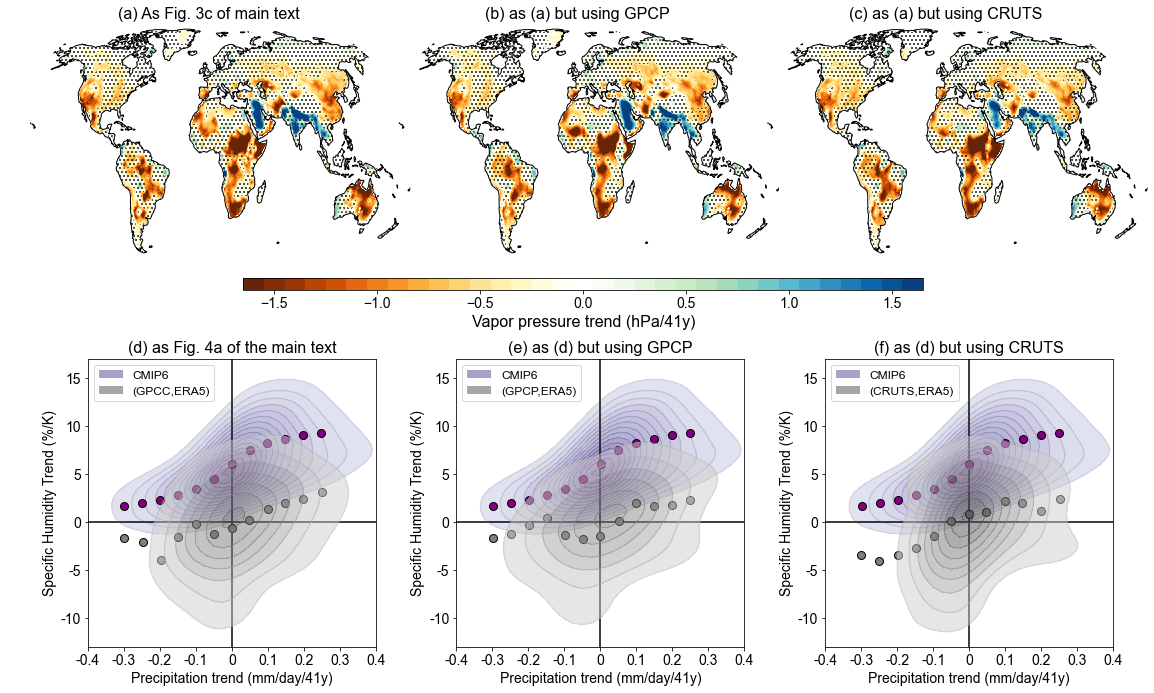

In [23]:
fig = plt.figure(figsize=(16,16))

import importlib
importlib.reload(mymaps)

ax = mymaps.contourmap_continentsonly_robinson_noborder_pos(fig, era5vptrenddif_gpcc*np.array(landfrac), era5map.lon, era5map.lat,0.1,-1.6,1.6,
                                                            '(a) As Fig. 3c of main text',
                                                            0.0,0.35,0.75,0.95,cmap='precip', signifdat=vpshading_afterp_gpcc, stipplesignif=True, fontsize=16)

ax = mymaps.contourmap_continentsonly_robinson_noborder_pos(fig, era5vptrenddif_gpcp*np.array(landfrac), era5map.lon, era5map.lat,0.1,-1.6,1.6,
                                                            '(b) as (a) but using GPCP',
                                                            0.32,0.67,0.75,0.95,cmap='precip', signifdat=vpshading_afterp_gpcp, stipplesignif=True, fontsize=16)


ax = mymaps.contourmap_continentsonly_robinson_noborder_pos(fig, era5vptrenddif_cruts*np.array(landfrac), era5map.lon, era5map.lat,0.1,-1.6,1.6,
                                                            '(c) as (a) but using CRUTS',
                                                            0.64,0.99,0.75,0.95,cmap='precip', signifdat=vpshading_afterp_cruts, stipplesignif=True, fontsize=16)




#---------------------------------------------GPCC
ax = setup_q_vs_pr(0.07,0.32,0.41,0.66,'(d) as Fig. 4a of the main text')
cmin=0.04 ; cmax=0.42 ; ci=0.02
ncontours = (cmax - cmin)/ci + 1

colors = plt.cm.Greys(np.linspace(0.3,1,np.int(ncontours+1-6)))
cmap = mpl.colors.ListedColormap(colors)
ax.contourf(x, y, zgpcc, cmap=cmap, levels=np.arange(cmin, cmax-6*ci, ci), alpha=0.5, zorder=10, label='(GPCC, ERA5)')
ax.contour(x, y, zgpcc, levels=np.arange(cmin, cmax, ci), colors='gray', alpha=0.15, zorder=11)
obslegend = Rectangle((0.95,0.95),5,3,facecolor=colors[3])

colors = plt.cm.Purples(np.linspace(0.3,1,np.int(ncontours)+1))
cmipcolors=colors
cmap = mpl.colors.ListedColormap(colors)
ax.contourf(x, y, zcmip6_weighted.mean('model'), cmap=cmap, levels=np.arange(cmin, cmax, ci), alpha=0.6, label='(CMIP6,CMIP6)')
ax.contour(x, y, zcmip6_weighted.mean('model'), levels=np.arange(cmin, cmax, ci), colors='gray', alpha=0.15)
cmiplegend = Rectangle((0.95,0.95),5,3,facecolor=colors[5])

plt.plot(pr_obs_gpcc, q_obs_gpcc, "o", markeredgecolor='black', markerfacecolor='gray', markersize=8)
plt.plot(pr_cmip6.mean('model'), q_cmip6.mean('model'),"o", markeredgecolor='black', markerfacecolor='purple', markersize=8)


legendparts = [cmiplegend, obslegend]
legendlabels = ['CMIP6','(GPCC,ERA5)']
ax.legend(legendparts, legendlabels, loc='upper left', prop={'size': 12})
#---------------
ax = cbars.plotcolorbar(fig, 0.1, -1.6, 1.6,'Vapor pressure trend (hPa/41y)', 0.205,0.795,0.72,0.73,cmap='precip')

#---------------------------------------------GPCP
ax = setup_q_vs_pr(0.39,0.64,0.41,0.66,'(e) as (d) but using GPCP')

colors = plt.cm.Greys(np.linspace(0.3,1,np.int(ncontours+1-6)))
cmap = mpl.colors.ListedColormap(colors)
ax.contourf(x, y, zgpcp, cmap=cmap, levels=np.arange(cmin, cmax-6*ci, ci), alpha=0.5, zorder=10, label='(GPCC, ERA5)')
ax.contour(x, y, zgpcp, levels=np.arange(cmin, cmax, ci), colors='gray', alpha=0.15, zorder=11)
obslegend = Rectangle((0.95,0.95),5,3,facecolor=colors[3])

colors = plt.cm.Purples(np.linspace(0.3,1,np.int(ncontours)+1))
cmipcolors=colors
cmap = mpl.colors.ListedColormap(colors)
ax.contourf(x, y, zcmip6_weighted.mean('model'), cmap=cmap, levels=np.arange(cmin, cmax, ci), alpha=0.6, label='(CMIP6,CMIP6)')
ax.contour(x, y, zcmip6_weighted.mean('model'), levels=np.arange(cmin, cmax, ci), colors='gray', alpha=0.15)
cmiplegend = Rectangle((0.95,0.95),5,3,facecolor=colors[5])

plt.plot(pr_obs_gpcp, q_obs_gpcp, "o", markeredgecolor='black', markerfacecolor='gray', markersize=8)
plt.plot(pr_cmip6.mean('model'), q_cmip6.mean('model'),"o", markeredgecolor='black', markerfacecolor='purple', markersize=8)

legendparts = [cmiplegend, obslegend]
legendlabels = ['CMIP6','(GPCP,ERA5)']
ax.legend(legendparts, legendlabels, loc='upper left', prop={'size': 12})
#---------------

#---------------------------------------------GPCP
ax = setup_q_vs_pr(0.71,0.96,0.41,0.66,'(f) as (d) but using CRUTS')

colors = plt.cm.Greys(np.linspace(0.3,1,np.int(ncontours+1-6)))
cmap = mpl.colors.ListedColormap(colors)
ax.contourf(x, y, zcruts, cmap=cmap, levels=np.arange(cmin, cmax-6*ci, ci), alpha=0.5, zorder=10, label='(GPCC, ERA5)')
ax.contour(x, y, zcruts, levels=np.arange(cmin, cmax, ci), colors='gray', alpha=0.15, zorder=11)
obslegend = Rectangle((0.95,0.95),5,3,facecolor=colors[3])

colors = plt.cm.Purples(np.linspace(0.3,1,np.int(ncontours)+1))
cmipcolors=colors
cmap = mpl.colors.ListedColormap(colors)
ax.contourf(x, y, zcmip6_weighted.mean('model'), cmap=cmap, levels=np.arange(cmin, cmax, ci), alpha=0.6, label='(CMIP6,CMIP6)')
ax.contour(x, y, zcmip6_weighted.mean('model'), levels=np.arange(cmin, cmax, ci), colors='gray', alpha=0.15)
cmiplegend = Rectangle((0.95,0.95),5,3,facecolor=colors[5])

plt.plot(pr_obs_cruts, q_obs_cruts, "o", markeredgecolor='black', markerfacecolor='gray', markersize=8)
plt.plot(pr_cmip6.mean('model'), q_cmip6.mean('model'),"o", markeredgecolor='black', markerfacecolor='purple', markersize=8)


legendparts = [cmiplegend, obslegend]
legendlabels = ['CMIP6','(CRUTS,ERA5)']
ax.legend(legendparts, legendlabels, loc='upper left', prop={'size': 12})
#---------------

fig.savefig(plotpath+'fig3and4with_other_precip.pdf', bbox_inches='tight', facecolor='white')